In [1]:
import numpy as np
import xarray as xr
import scipy
import gdal
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction

import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline


### Setup function to ensure data is correct shape for resampling

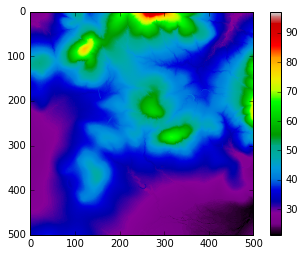

In [2]:
# Setup initial input data.
location = (r'/g/data/xc0/user/walker/sjw603/dem_5m')
os.chdir(location)
ds = gdal.Open('fit_3_dem.tif')
x = np.array(ds.GetRasterBand(1).ReadAsArray())
input_DEM = x[3000:3500, 3000:3500]

plt.imshow(input_DEM, cmap="nipy_spectral")
plt.colorbar()



In [22]:
chunk_size = 10
chunk_rows = np.array_split(input_DEM, chunk_size, axis = 0)
for i in range(0, len(chunk_rows)):
    row_chunk = chunk_rows[i]
    chunk_cols = np.array_split(row_chunk, chunk_size, axis = 1)
    for i in range(0, len(chunk_cols)):
        working_chunk = chunk_cols[i]
        print (np.amax(working_chunk))
    




-999.0
-999.0
-999.0
-999.0
213.458
240.878
116.435
-999.0
-999.0
-999.0
-999.0
-999.0
-999.0
99.7708
201.571
205.763
254.0
-999.0
-999.0
-999.0
-999.0
-999.0
56.2032
180.553
188.893
148.201
93.0928
-999.0
-999.0
-999.0
-999.0
260.536
71.996
190.946
83.616
45.286
41.922
24.4712
20.3052
18.8936
-999.0
208.766
118.306
47.6832
102.474
103.544
37.0988
23.9584
22.854
23.1532
-999.0
150.539
86.7556
52.2536
67.2864
61.5732
101.454
49.3468
18.7852
17.9704
170.7
193.592
132.402
68.7652
59.5644
74.4756
75.2188
-999.0
-999.0
15.35
320.378
150.24
233.804
116.628
71.116
87.6672
-999.0
-999.0
-999.0
-999.0
392.239
240.911
243.964
191.5
177.791
65.3536
-999.0
-999.0
-999.0
-999.0
442.683
423.681
485.685
285.025
-999.0
-999.0
-999.0
-999.0
-999.0
-999.0


[[ 278.68394765  263.34871354  263.83568433 ...,    0.            0.            0.        ]
 [ 263.31998742    3.08948881    2.90875283 ...,    0.            0.            0.        ]
 [ 264.91377548    2.93232096    2.73119375 ...,    0.            0.            0.        ]
 ..., 
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]]
30
4
[[ 0.          0.17241379  0.17241379 ...,  0.          0.          0.        ]
 [ 0.20689655  0.24137931  0.37931034 ...,  0.          0.          0.        ]
 [ 0.13793103  0.31034483  0.51724138 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0

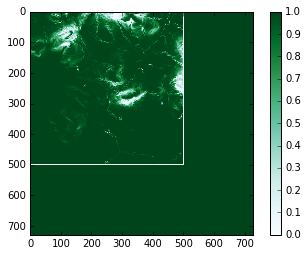

In [31]:
# Setup initial input data.
#location = (r'/g/data/xc0/user/walker/sjw603/dem_5m')
#os.chdir(location)
#ds = gdal.Open('fit_3_dem.tif')
#input_DEM = np.array(ds.GetRasterBand(1).ReadAsArray())

# Specify initial data resolution.

initial_resolution = 5

# First check that the x axis y axis of the array are in multiples of the desired resolution ratio so that 
# resampling up and down will always result in an output of equal size to the original input DEM.
# In the case of MRVBF the reoslution ratio is 3 (but this can be varied).

def x_y_size_test(input_array, resolution_ratio, resample_levels, number_of_options):
    
    """This function checks the size of the array and ensures that it can be resampled up and down 
    by a factor of three and always result in an array of the original size."""
    
    # Check number of rows and columns. 
    rows = np.size(input_array, 0)
    columns = np.size(input_array, 1)
    
    array_sizes = []
    for i in range(1,number_of_options):
        min_dim_size = resolution_ratio ** resample_levels
        ideal_array = i * min_dim_size
        array_sizes.append(ideal_array)

    ideal_row = next(x[1] for x in enumerate(array_sizes) if x[1] > rows)
    ideal_col = next(x[1] for x in enumerate(array_sizes) if x[1] > columns)
    
    add_rows = ideal_row - rows
    add_columns = ideal_col - columns
    
    empty_array = np.zeros((rows + add_rows, columns + add_columns)) # Create an empty array to the pad if required.
    
    offset_rows = int(-1 * add_rows)
    offset_columns = int(-1 * add_columns)
    
    empty_array[:offset_rows, :offset_columns] = input_array
    
    return empty_array

# Create a mask to apply to final output

# Create a mask to apply to final output

# np.copy is used here because if an array is just mapped to a variable then changes to the new array will also be made 
# to the original array. Using np.copy creates a unique instance of the original array that can then be changed.

mask_template = np.copy(input_DEM)
mask_template[mask_template == -999] = np.nan
mask_template[mask_template != -999] = 1
mask = x_y_size_test(mask_template, 3, 5, 20)
mask


# Use x_y_size_test function to pad input file by required amount

DEM = x_y_size_test(input_DEM, 3, 5, 20)
DEM[DEM == -999] = 0

# Setup predefined list of slope thresholds to be applied depending on starting resolution of data.

# Within algorithm adjust the indexing simply follows the value of the current step L (including step 1 and 2).

# For a starting resolution of 1m these resolution decreases follow the sequence 1, 3, 8, 25, ...
# For a starting resolution of 5m these resolution decreases follow the sequence 5, 15, 45, ...
# For a starting resolution of 25m these resolution decreases follow the sequence 25, 75, 225, ...

ts_list_1m = [45, 36.5, 28, 16, 8, 4, 2, 1] #Here step 1 == 36.5, step 2 == 28, step 3 == 16 ... etc
ts_list_5m = [45, 32.5, 20, 10, 5, 2, 1] #Here step 1 == 32.5, step 2 == 20, step 3 == 10 ... etc
ts_list_25m = [45, 16, 8, 4, 2, 1] #Here step 1 == 16, step 2 == 8, step 3 == 4 ... etc

# NOTE: 45 is only in here to represent the maximum possible angle of repose.

# These values are all calculate using Equation 1 with x = data resolution, t = 13 and p = 1. 
# The membership value produced is multiplied by a specified maximum angle of repose (here 100 percent (45 degrees)).
# This setup allows 



# Setup some resampling functions.

def resample_resolution_lower(data, ratio):
    
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    
    zoom_factor = Fraction(1,3 ** ratio)
    
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    
    return resample

# First setup functions for changing resolution of data

def resample_resolution_higher(data, ratio):
    
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    
    zoom_factor = 3 ** ratio
    
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    
    return resample

# Setup functions to calculate slope for input DEM

def rectangleWindow(m, n):
    
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    
    rectangle = np.ones((m, n), dtype=bool) 

    return rectangle

def number_of_values(Window):
            
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
        
    denominator = sum(sum(Window > 0))
    
    return denominator

#Note: using median like this only gives the correct value for circles with odd radius values.

def slopeWindow(DEM, x_cellsize, y_cellsize):
    
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
        
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
       
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    
    slope_percent = rise_run * 100
    
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent

# The 'extra_arguments' variable requires a value that represents r in the PCTL function defined above.
# The reason it need to be assigned to a seperate variable is that the generic_filter function only allows the
# input function (PCTL in this case) to take one argument (S1). Then, if the input function normally takes more
# than one argument the 'extra_arguments' variable needs to be defined as a tuple (hence (3,) instead of (3)).

# This would be a slope raster with slope represented as percent.

S1 = generic_filter(DEM, slopeWindow, footprint= rectangleWindow(3,3), mode='constant', extra_arguments = (5,5,))

# First define a non-linear function for mapping  output values onto the range 0 to 1.

# Equation 1

def Nxtp(x, t, p):
    
    """Takes a DEM derivative (x, such as slope or elevation percentile 
    and maps it onto the range [0,1] using a non-linear equation with a shape 
    parameter (t) and a threshold parameter (p)"""
    
    standardise_value = 1/(1+(x/t)**p)
    print (x)
    print (t)
    print (p)
    return standardise_value

# Finest-Scale step

# Equation 2

# The x value here is the slope raster S1 (with slope as percent).
# In the paper the threshold value (t) at this stage is 16%.

# Equation from paper F1 = N(S1, ts,1, 4)

F1 = Nxtp(S1, 30, 4)

# Calculate elevation percentiles

# Define a function that takes a value for radius and creates a circular window using that radius.

def circleWindow(radius):
    
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle

def number_of_values(Window):
            
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == circle type 'number_of_values(circleWindow(r)) 
        where r is any positive real number as per the circleWindow function."""
        
    denominator = sum(sum(Window > 0))
    return denominator

#Note: using median like this only gives the correct value for circles with odd radius values.

def find_median_value(Window):
    
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer."""
    
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value

# Define a function to be used by the generic_filter function.

#This function calculates the percentile of a central value within its circular neighborhood.

def PCTL(x):
    
    """This function only works as an inside function to generic_filter function below. This
    is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
    step the 'central_value' variable will be outside of the array dimensions. 
    x = input DEM and r = radius of search window """
    
    centroid = x[central_value]                        
    y = np.sum(x > centroid)/num_values#Count number of values greater than centroid value
    return y

# Calculate elevation percentile with a radius of 3. Use percentile_filter from ndimage.

radius = 3

central_value = find_median_value(circleWindow(radius))

num_values = number_of_values(circleWindow(radius))

PCTL1 = generic_filter(S1, PCTL, footprint= circleWindow(3), mode='constant')

# Equation 3

#This is the same as first defining a variable for 'standardised elevation percentile' 
#and then multiplying it by standardised slope. Instead the elevation percentile is being standardised 
#at the same time as being multiplied by F1 (standardised slope).

#The x position here is elevation percentile raster.

PVF1 = F1 * Nxtp(PCTL1, 0.4, 3)

# Equation 4

#This tansforms valley bottom scores to represent areas likely to be valley floors as values > 0.50.

VF1 = 1 - Nxtp(PVF1, 0.3, 4)

# Second step

# Equation 5

#Here S2 is defined as the original input DEM raster. It is only being assigned to the variable S2 to keep the 
#equation notation consistent with the paper.

S2 = np.copy(S1)

#Same as first operation in step one except the slope percent threshold is halved to 8%.

#I'm using 16% here because I started with 30%.

#The x variable again is the slope raster represented as slope percent.

F2 = Nxtp(S2,16,4)

# Calculate elevation percentile with a radius of 6.

radius = 6

central_value = find_median_value(circleWindow(radius))

num_values = number_of_values(circleWindow(radius))

PCTL2 = generic_filter(S2, PCTL, footprint= circleWindow(radius), mode='constant')

# Equation 6.

PVF2 = F2 * Nxtp(PCTL2, 0.4, 3)

# Equation 7

VF2 = 1 - Nxtp(PVF2, 0.3, 4)

# Equation 9

# Equation 9 is being defined before equation 8 because it is a required input to equaiton 8.

# W2 = 1 - N(VF2, t, p2)

W2 = 1 - Nxtp(VF2, 0.4, 6.68) # t = 0.5 and p2 = 6.68 are parameter values taken stright from the paper but can be varied.

# Equation 8

# MRVBF2 = W2(1 + VF2) + (1 - W2)VF1 

MRVBF2 = W2 * (1 + VF2) + (1 - W2)*VF1

# Equation 10.

CF2 = F1*F2



## Now allow any number of generalisation steps.

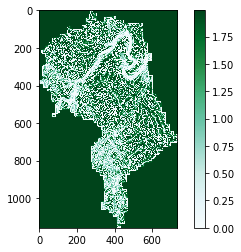

In [10]:
#First populate dictionary with outputs from Second Step.

array_LL = {}
ts_list = [2, 4, 8, 16, 28, 36, 42]
array_LL.setdefault('DEM11', []).append(DEM); 
array_LL.setdefault('DEM22', []).append(DEM);
array_LL.setdefault('F21', []).append(F2); 
array_LL.setdefault('CF21', []).append(CF2); 
array_LL.setdefault('MRVBF21', []).append(MRVBF2);


#array_LL.setdefault('ts', []).append(); # Needs to be defined probably from a list above the loop containing all ts values

p = array_LL['MRVBF21'][0]
p.shape
plt.imshow(p, cmap="BuGn")
plt.colorbar()


In [91]:
test = np.random.rand(10,10)
test
a = x_y_size_test(test,3, 5, 20)
a.shape
a
b = resample_resolution_lower(a,1)
b.shape
c = x_y_size_test(b,3, 5, 20)
c.shape



(6, 6)

In [25]:
# Remaining steps.

# Now smooth the DEM

#First populate dictionary with outputs from Second Step.

array_LL = {}
ts_list = [2, 4, 8, 16, 28, 36, 42]
array_LL.setdefault('DEM22', []).append(DEM);
array_LL.setdefault('F21', []).append(F2); 
array_LL.setdefault('CF21', []).append(CF2); 
array_LL.setdefault('MRVBF21', []).append(MRVBF2);

for i in range(3,4): 
    L = str(i) 
    Lm1 = str(i - 1)   
    # DEM L, L-1. A smoothed DEM without change of resolution.
    
    DEML_Lm1 = median_filter(array_LL['DEM'+ Lm1 + Lm1][0], size=7, mode='constant')
    
    array_LL.setdefault('DEM'+ L + Lm1, []).append(DEML_Lm1);
    


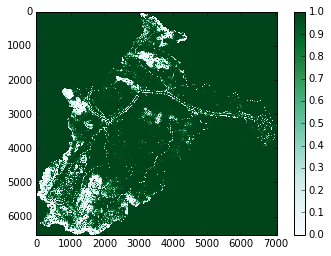

In [28]:
p = array_LL['CF'+ Lm1 + '1'][0]
p.shape
plt.imshow(p, cmap="BuGn")
plt.colorbar()

In [34]:
DEML_L.shape
a = resample_resolution_lower(DEML_L, 1)
a.shape
b = resample_resolution_higher(a, 2)
b.shape


(729, 729)

[[  462.53269909  1037.67121565  1474.0384767  ...,     0.             0.
      0.        ]
 [ 1037.67121565  1400.92702126  1050.80295978 ...,     0.             0.
      0.        ]
 [ 1474.85068883  1051.89140004    15.59263074 ...,     0.             0.
      0.        ]
 ..., 
 [    0.             0.             0.         ...,     0.             0.
      0.        ]
 [    0.             0.             0.         ...,     0.             0.
      0.        ]
 [    0.             0.             0.         ...,     0.             0.
      0.        ]]
28
4
[[ 0.30088496  0.3155937   0.33030244 ...,  0.          0.          0.        ]
 [ 0.31265195  0.32442703  0.3362021  ...,  0.          0.          0.        ]
 [ 0.32441894  0.33326035  0.34210176 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0

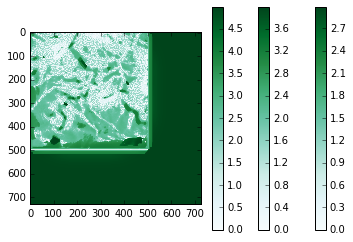

In [36]:
-


In [41]:
input_DEM.shape

(500, 500)

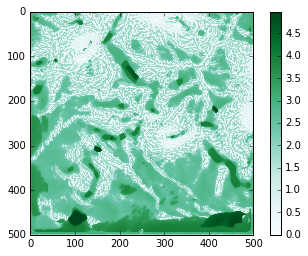

In [42]:
plt.imshow(MRVBFL_1[0:500, 0:500], cmap="BuGn")
plt.colorbar()

# Visualise output

In [ ]:
MRVBF3_f = MRVBF3_1 * mask

plt.imshow(MRVBF3_f, cmap="BuGn")
plt.colorbar()



# Write output to GeoTIFF

In [ ]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = ds.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

np_array_to_Geotiff('mar_54_pctl.tif', ds, PCTL3_1, MRVBF3_f.dtype)